# An example of mastrplan creation

In [1]:
import pandas as pd
import networkx as nx
import geopandas as gpd
from IPython.display import Image, display
import matplotlib.pyplot as plt

from masterplan_tools.City_model.city_model import CityModel
from masterplan_tools.Provision_getter.provision_getter import ProvisionModel
from masterplan_tools.Balancer.balancer import MasterPlan
from masterplan_tools.Data_getter.data_getter import DataGetter

c:\masterplanning\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### City model creation

In [2]:
# To assess services provision they must be specified as a list of strings
# Service names must be the same as in your data

# service_types = ["schools", "kindergartens", "recreational_areas"]

In [3]:
# path to data
path = "../masterplanning/mp_data/"

# load data required for blocks creation
city_geometry = gpd.read_parquet(path + "city_geometry.parquet")
water_geometry = gpd.read_parquet(path + "water_geometry.parquet")
roads_geometry = gpd.read_parquet(path + "roads_geometry.parquet")
railways_geometry = gpd.read_parquet(path + "railways_geometry.parquet")
nature_geometry_boundaries = gpd.read_parquet(path + "nature_geometry_boundaries.parquet")

# load data required for service graphs creation
schools = gpd.read_parquet(path + "schools.parquet")
kindergartens = gpd.read_parquet(path + "kindergartens.parquet")
recreational_areas = gpd.read_parquet(path + "recreational_areas.parquet")
# accessibility_matrix = pd.read_pickle(path + "accessibility_matrix.pkl")

# load data required for
buildings = gpd.read_parquet(path + "buildings.parquet")
greenings = gpd.read_parquet(path + "greenings.parquet")
parkings = gpd.read_parquet(path + "parkings.parquet")
transport_graph = nx.read_graphml(path + "new_graph.graphml")

# data loading with planning area
polygon = gpd.gpd.read_file(path + "polygon.geojson")

In [4]:
# services should be specified as a dictionary
services = {"schools": schools, "kindergartens": kindergartens, "recreational_areas": recreational_areas}

In [5]:
# City data model creation
city_model = CityModel(
    services=services,
    city_geometry=city_geometry,
    water_geometry=water_geometry,
    roads_geometry=roads_geometry,
    railways_geometry=railways_geometry,
    nature_geometry_boundaries=nature_geometry_boundaries,
    # accessibility_matrix=accessibility_matrix,
    transport_graph=transport_graph,
    buildings=buildings,
    greenings=greenings,
    parkings=parkings,
)

2023-05-23 18:03:04.145 | INFO     | masterplan_tools.Blocks_getter.blocks_getter:_cut_railways:133 - Starting: cutting railways geometries
2023-05-23 18:03:04.162 | INFO     | masterplan_tools.Blocks_getter.blocks_getter:_cut_railways:140 - Finished: cutting railways geometries
2023-05-23 18:03:04.163 | INFO     | masterplan_tools.Blocks_getter.blocks_getter:_cut_roads:151 - Starting: cutting roads geometries
2023-05-23 18:03:04.577 | INFO     | masterplan_tools.Blocks_getter.blocks_getter:_cut_roads:158 - Finished: cutting roads geometries
2023-05-23 18:03:04.578 | INFO     | masterplan_tools.Blocks_getter.blocks_getter:_cut_nature:171 - Starting: cutting nature geometries
2023-05-23 18:03:04.693 | INFO     | masterplan_tools.Blocks_getter.blocks_getter:_cut_nature:178 - Finished: cutting nature geometries
2023-05-23 18:03:04.694 | INFO     | masterplan_tools.Blocks_getter.blocks_getter:_fill_deadends:91 - Starting: filling deadends
2023-05-23 18:03:04.784 | INFO     | masterplan_too

#### Calculating the provision of services in blocks

In [6]:
services_prov = {}

for service_type in services.keys():
    provision = ProvisionModel(city_model=city_model, service_name=service_type)
    print(service_type)
    services_prov[service_type] = provision.run()

schools
Number of blocks with service: schools: 28
Number of residential blocks: 114
Number of blocks total: 199
Number of blocks with an error: 0
kindergartens
Number of blocks with service: kindergartens: 32
Number of residential blocks: 114
Number of blocks total: 199
Number of blocks with an error: 0
recreational_areas
Number of blocks with service: recreational_areas: 151
Number of residential blocks: 114
Number of blocks total: 199
Number of blocks with an error: 0


#### Service provision visualization

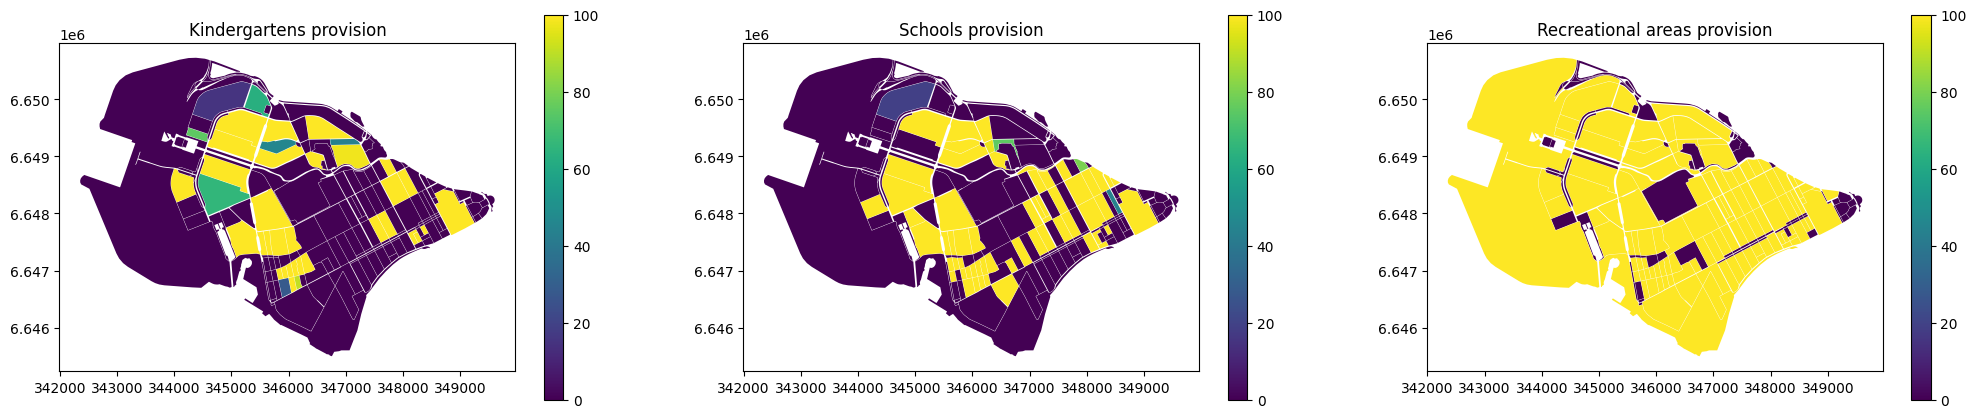

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5))

services_prov["kindergartens"].plot(column="provision_kindergartens", legend=True, ax=ax1)
ax1.set_title("Kindergartens provision")

services_prov["schools"].plot(column="provision_schools", legend=True, ax=ax2)
ax2.set_title("Schools provision")

services_prov["recreational_areas"].plot(column="provision_recreational_areas", legend=True, ax=ax3)
ax3.set_title("Recreational areas provision")

plt.show()

#### Selected area of the city to which the new parameters will be modelled

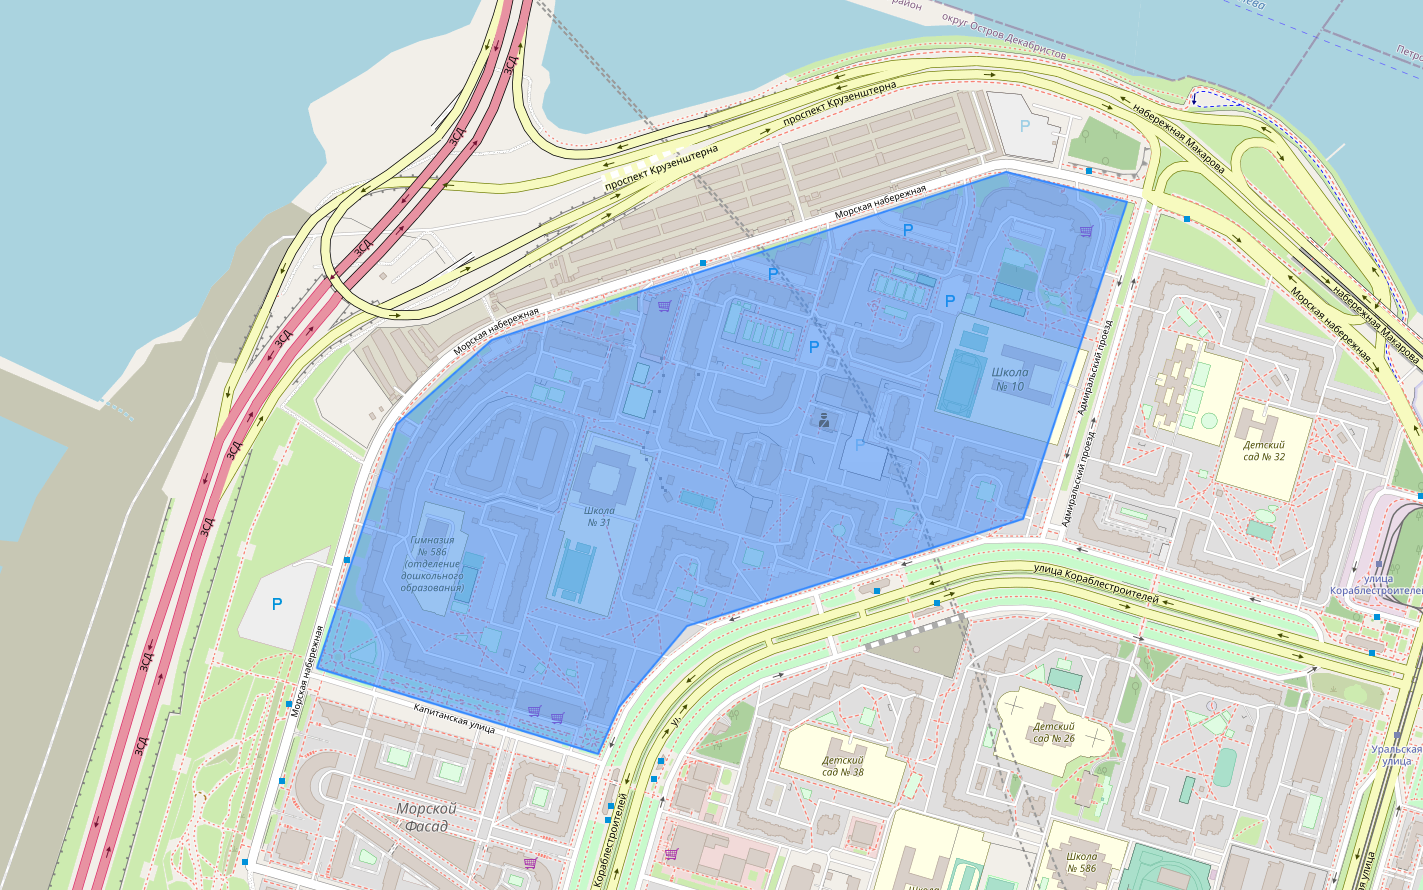

In [8]:
display(Image(filename="../masterplanning/img/polygon.png", embed=True))

In [17]:
block = DataGetter().balance_data(
    gdf=city_model.blocks_aggregated_info,
    polygon=polygon,
    school=services_prov["schools"],
    kindergarten=services_prov["kindergartens"],
    greening=services_prov["recreational_areas"],
)
block

{'block_id': 24.0,
 'area': 39.81881724414382,
 'current_living_area': 5.0037369,
 'current_industrial_area': 1.3555672700000003,
 'current_population': 14424.0,
 'current_green_area': 1.0476,
 'floors': 4.0,
 'population_unprov_schools': 11665.0,
 'population_unprov_kindergartens': 12194.0,
 'population_unprov_recreational_areas': 0.0}

This territory has the following technical and economic indicators

| Key | Techno-economic indicator |
| --- | --- |
| block_id | 24 |
| area | 39.81881724414382 |
| current_living_area | 5.0037369 |
| current_industrial_area | 1.3555672700000003 |
| current_population | 14424 |
| current_green_area | 1.0476 |
| floors | 4.0 |
| population_unprov_schools | 11665.0 |
| population_unprov_kindergartens | 12194.0 |
| population_unprov_recreational_areas | 0.0 |

#### Modelling of new parameters for the selected area with maximisation of the number of inhabitants

In [9]:
mp = MasterPlan(
    area=block["area"],
    current_living_area=block["current_living_area"],
    current_industrial_area=block["current_industrial_area"],
    current_population=block["current_population"],
    current_green_area=block["current_green_area"],
    current_unprov_schoolkids=block["population_unprov_schools"],
    current_unprov_kids=block["population_unprov_kindergartens"],
    current_unprov_green_population=block["population_unprov_recreational_areas"],
)

updated_block = mp.optimal_solution_indicators()
updated_block["block_id"] = 24

c:\masterplanning\masterplan_tools\Balancer\balancer.py:352: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(temp_result, ignore_index=True)
c:\masterplanning\masterplan_tools\Balancer\balancer.py:352: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(temp_result, ignore_index=True)
c:\masterplanning\masterplan_tools\Balancer\balancer.py:352: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(temp_result, ignore_index=True)
c:\masterplanning\masterplan_tools\Balancer\balancer.py:352: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = 

#### Modelled block transformation requirements

In [11]:
updated_block

{'area': 39.81881724414382,
 'population': 18807.0,
 'b': 30.0,
 'green_coef_G': 5.999999999999999,
 'living_area': 18.1527369,
 'schools_area': 3.6,
 'schools_capacity': 2200.0,
 'kindergartens_area': 0.72,
 'kindergartens_capacity': 180.0,
 'green_area': 3.6774,
 'G_min_capacity': 6129.000000000001,
 'G_max_capacity': 3064.5000000000005,
 'green_coef_G_capacity': 6129.000000000001,
 'op_area': 0.013149000000000001,
 'parking1_area': 3.3135480000000004,
 'parking2_area': 3.221505,
 'block_id': 24}

| Key | Requirement |
| --- | --- |
| block_id | 24 |
| area | 39.81881724414382 |
| population | 18807 |
| b | 30.0 |
| green_coef_G | 5.999999999999999 |
| living_area | 18.1527369 |
| schools_area | 3.6 |
| schools_capacity | 2200.0 |
| kindergartens_area | 0.72 |
| kindergartens_capacity | 180.0 |
| green_area | 3.6774 |
| G_min_capacity | 6129.000000000001 |
| G_max_capacity | 3064.5000000000005 |
| green_coef_G_capacity | 6129.000000000001 |
| op_area | 0.013149000000000001 |
| parking1_area | 3.3135480000000004 |
| parking2_area | 3.221505 |


#### Making changes based on requirements in the data model

In [12]:
services_graph = nx.Graph()
for service_type in services.keys():
    service_graph = DataGetter().prepare_graph(
        blocks=city_model.city_blocks,
        service_type=service_type,
        buildings=city_model.buildings,
        service_gdf=city_model.services_gdfs[service_type],
        updated_block_info=updated_block,
        accessibility_matrix=city_model.accessibility_matrix,
        services_graph=services_graph,
    )

city_model.services_graph = services_graph

100%|██████████| 151/151 [00:00<00:00, 1072.02it/s]


#### Recalculating the provision of services to blocks

In [13]:
services_prov_nev = {}

for service_type in services.keys():
    provision = ProvisionModel(city_model=city_model, service_name=service_type)
    services_prov_nev[service_type] = provision.run()

Number of blocks with service: schools: 28
Number of residential blocks: 114
Number of blocks total: 199
Number of blocks with an error: 0
Number of blocks with service: kindergartens: 32
Number of residential blocks: 114
Number of blocks total: 199
Number of blocks with an error: 0
Number of blocks with service: recreational_areas: 151
Number of residential blocks: 114
Number of blocks total: 199
Number of blocks with an error: 0


#### New service provision visualization

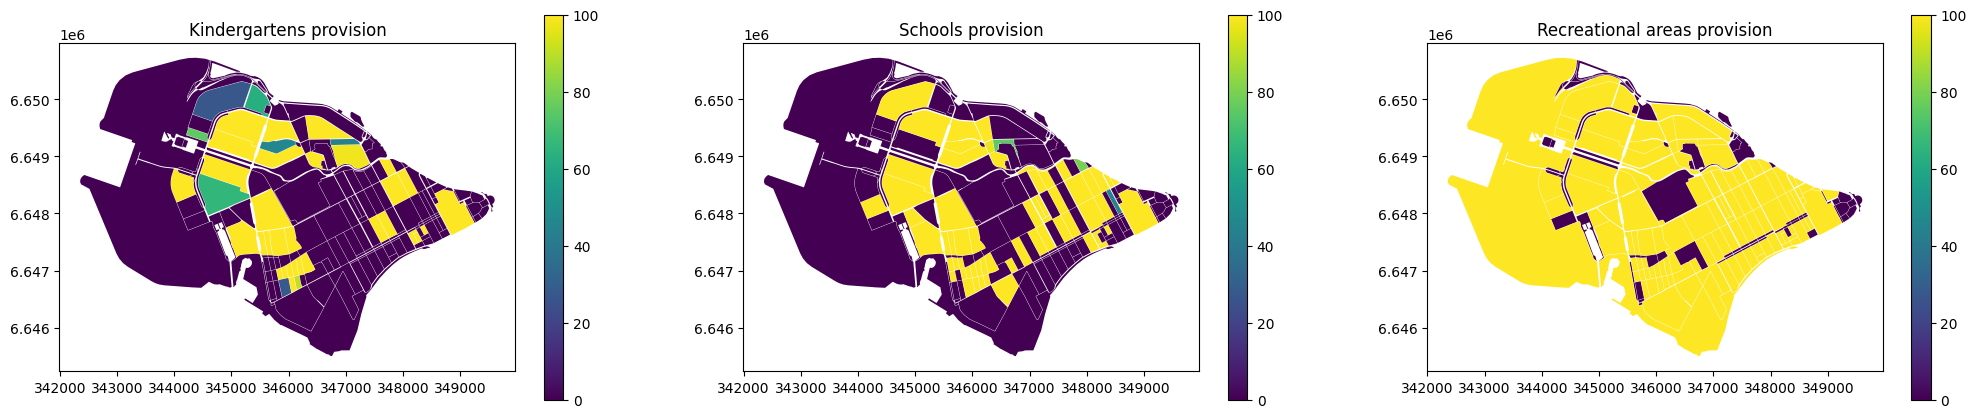

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5))

services_prov_nev["kindergartens"].plot(column="provision_kindergartens", legend=True, ax=ax1)
ax1.set_title("Kindergartens provision")

services_prov_nev["schools"].plot(column="provision_schools", legend=True, ax=ax2)
ax2.set_title("Schools provision")

services_prov_nev["recreational_areas"].plot(column="provision_recreational_areas", legend=True, ax=ax3)
ax3.set_title("Recreational areas provision")

plt.show()

#### Comparison of service provision before and after the territory change

In [14]:
display("Results of calculating the provision of the kindergarten service for a single block")
display(services_prov["kindergartens"].iloc[24])
display(services_prov_nev["kindergartens"].iloc[24])
display("Results of calculating the provision of the recreational_areas service for a single block")
display(services_prov["schools"].iloc[24])
display(services_prov_nev["schools"].iloc[24])
display("Results of calculating the provision of the recreational_areas service for a single block")
display(services_prov["recreational_areas"].iloc[24])
display(services_prov_nev["recreational_areas"].iloc[24])

'Results of calculating the provision of the kindergarten service for a single block'

id                                                                                24
geometry                           POLYGON ((344426.35412361793 6650019.612956254...
provision_kindergartens                                                           15
population_prov_kindergartens                                                   2229
population_unprov_kindergartens                                                12194
population                                                                     14424
Name: 24, dtype: object

id                                                                                24
geometry                           POLYGON ((344426.35412361793 6650019.612956254...
provision_kindergartens                                                           27
population_prov_kindergartens                                                   5180
population_unprov_kindergartens                                                13626
population                                                                     18807
Name: 24, dtype: object

'Results of calculating the provision of the recreational_areas service for a single block'

id                                                                          24
geometry                     POLYGON ((344426.35412361793 6650019.612956254...
provision_schools                                                           19
population_prov_schools                                                   2758
population_unprov_schools                                                11665
population                                                               14424
Name: 24, dtype: object

id                                                                          24
geometry                     POLYGON ((344426.35412361793 6650019.612956254...
provision_schools                                                          100
population_prov_schools                                                  18807
population_unprov_schools                                                    0
population                                                               18807
Name: 24, dtype: object

'Results of calculating the provision of the recreational_areas service for a single block'

id                                                                                     24
geometry                                POLYGON ((344426.35412361793 6650019.612956254...
provision_recreational_areas                                                          100
population_prov_recreational_areas                                                  14424
population_unprov_recreational_areas                                                    0
population                                                                          14424
Name: 24, dtype: object

id                                                                                     24
geometry                                POLYGON ((344426.35412361793 6650019.612956254...
provision_recreational_areas                                                          100
population_prov_recreational_areas                                                  18807
population_unprov_recreational_areas                                                    0
population                                                                          18807
Name: 24, dtype: object